In [1]:
import tensorflow as tf
import numpy as np
from gbica_utils import *
from tf_powersfa import *
from tensorflow.keras.layers import *
from tensorflow.nn import *

In [2]:
n_out = 2
n_hidden = 16

In [3]:
batch_size = 1000
N = 998


encoding_x = tf.placeholder("float", [N, n_out])
with tf.name_scope("encoder"):
    dense0 = leaky_relu(tf.keras.layers.Dense(n_hidden)(encoding_x))
    dense1 = leaky_relu(tf.keras.layers.Dense(n_hidden)(dense0))
    dense2 = tf.keras.layers.Dense(n_out)(dense1)


encoder_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='encoder')

dense = alt_power_whitening(dense2, n_out, 50)[0]

In [4]:
n_hidden = 20

x, y = tf.split(dense, n_out, axis=1)

y_ = permute_y(y, N)

h_join = tf.concat([y, x], axis=1)
h_marg = tf.concat([y_, x], axis=1)
learning_rate_encoder = tf.placeholder(tf.float32, shape=[])
learning_rate_estimator = 0.002
with tf.name_scope("estimator"):
    estimator1 = Dense(n_hidden)
    estimator2 = Dense(n_hidden)
    estimator3 = Dense(n_hidden)
    estimator4 = Dense(n_hidden)
    estimator5 = Dense(n_hidden)
    
    def estimator_net_simple(h_join, h_marg, estimator): 
        dense1_joint = leaky_relu(estimator[0](h_join))
        dense2_joint = leaky_relu(estimator[1](dense1_joint))
        dense3_joint = leaky_relu(estimator[2](dense2_joint))
        dense4_joint = leaky_relu(estimator[3](dense3_joint))
        dense5_joint = estimator[4](dense4_joint)

        dense1_marg = leaky_relu(estimator[0](h_marg))
        dense2_marg = leaky_relu(estimator[1](dense1_marg))
        dense3_marg = leaky_relu(estimator[2](dense2_marg))
        dense4_marg = leaky_relu(estimator[3](dense3_marg))
        dense5_marg = estimator[4](dense4_marg)
        return dense5_joint, dense5_marg
    
    dense5_joint, dense5_marg = estimator_net_simple(h_join, h_marg,
                                                   [estimator1, estimator2, estimator3, estimator4, estimator5])

estimator_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='estimator')


regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)

for var in estimator_var_list:
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, var)
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)


loss = tf.reduce_mean(dense5_joint)-tf.log(tf.reduce_mean(tf.exp(dense5_marg)))
train_encoder     = tf.train.AdamOptimizer(learning_rate_encoder).minimize(loss, var_list=encoder_var_list)
train_step = tf.contrib.opt.NadamOptimizer(learning_rate_estimator).minimize(-(loss+reg_term), var_list=estimator_var_list)

/home/hlynur/.local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 2
  warnings.warn('n_components is too large: it will be set to %s' % n_components)


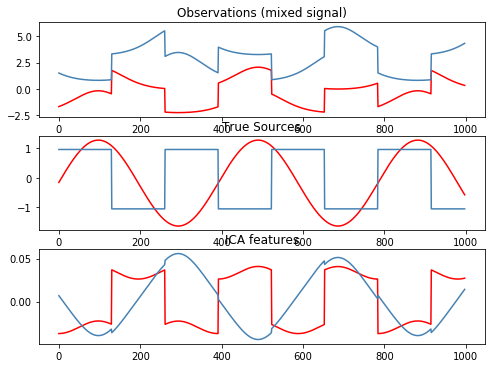

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA

time = np.linspace(0, 8, batch_size)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s1 -= np.mean(s1)
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s2 -= np.mean(s2)
S = np.c_[s1, s2]
S += 0.0 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1], [0.5, 2]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

for t in range(X.shape[0]):    
    X[t, 0] = np.exp(s1[t]) - np.exp(s2[t])
    X[t, 1] = np.exp(-s1[t]) + np.exp(-s2[t])
S = S[1:-1,:]
X = X[1:-1,:]

# Solve the task with FastICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals


models = [X, S, S_]
names = ['Observations (mixed signal)', 'True Sources', 'ICA features']
colors = ['red', 'steelblue']
plt.figure(figsize=(8, 8))
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.show()

step: 0, loss: -0.0035585593432188034


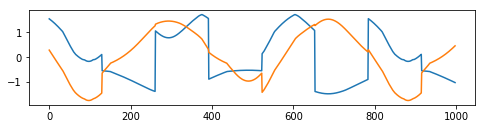

step: 100, loss: 0.26391056180000305
step: 200, loss: 0.7039152383804321
step: 300, loss: 1.1012344360351562
step: 400, loss: 0.7512611150741577


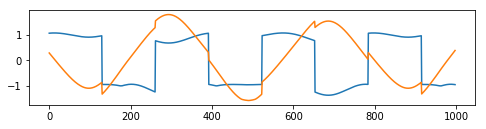

step: 500, loss: 1.119290828704834
step: 600, loss: 1.0816984176635742
step: 700, loss: 0.33163928985595703
step: 800, loss: 0.46375083923339844


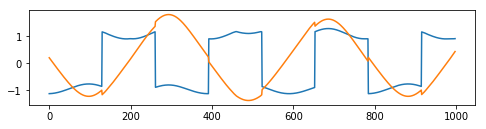

step: 900, loss: 0.9187188148498535
step: 1000, loss: 0.9701662063598633
step: 1100, loss: 1.175236701965332
step: 1200, loss: 0.5986356735229492


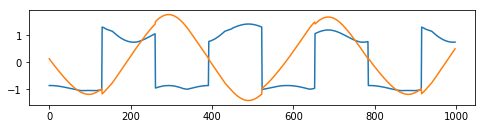

step: 1300, loss: 0.9612443447113037
step: 1400, loss: 1.1116654872894287
step: 1500, loss: 0.7141156196594238
step: 1600, loss: -0.09809684753417969


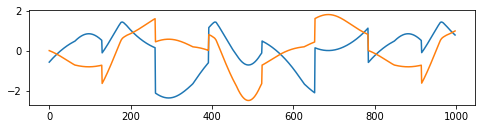

step: 1700, loss: 0.9080610275268555
step: 1800, loss: 0.6492996215820312
step: 1900, loss: 0.6863212585449219
step: 2000, loss: 1.1067428588867188


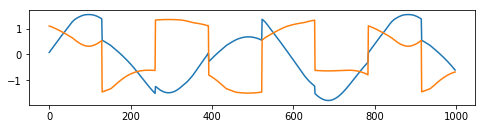

step: 2100, loss: 0.02909088134765625
step: 2200, loss: 0.7990350723266602
step: 2300, loss: 0.7973232269287109
step: 2400, loss: 0.7698955535888672


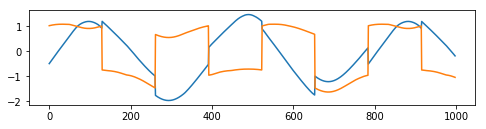

step: 2500, loss: 0.4982318878173828
step: 2600, loss: 0.7397823333740234
step: 2700, loss: 0.6623735427856445
step: 2800, loss: 0.6366310119628906


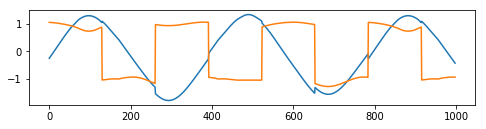

step: 2900, loss: 0.6112327575683594
step: 3000, loss: 0.675724983215332
step: 3100, loss: 0.5063319206237793
step: 3200, loss: -0.42360687255859375


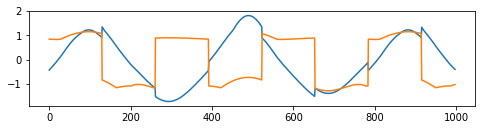

step: 3300, loss: 0.4534878432750702
step: 3400, loss: 0.9956061840057373
step: 3500, loss: 1.0865092277526855
step: 3600, loss: 0.25802040100097656


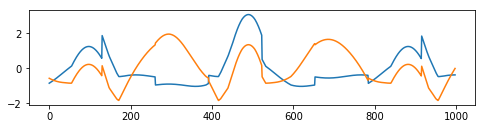

step: 3700, loss: 1.0421152114868164
step: 3800, loss: 0.28999900817871094
step: 3900, loss: 0.9794883728027344
step: 4000, loss: 1.3063526153564453


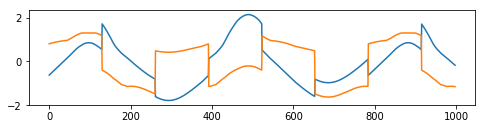

step: 4100, loss: 1.0516490936279297
step: 4200, loss: -0.07078742980957031
step: 4300, loss: 0.7616310119628906
step: 4400, loss: 0.06251144409179688


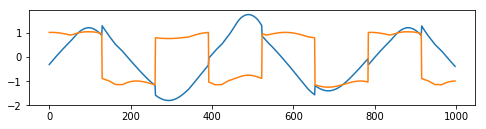

step: 4500, loss: 0.8687553405761719
step: 4600, loss: 0.5592727661132812
step: 4700, loss: 0.8953437805175781
step: 4800, loss: 0.7026023864746094


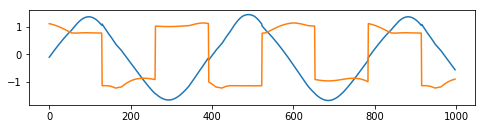

step: 4900, loss: -0.1785125732421875
step: 5000, loss: 0.9798202514648438
step: 5100, loss: 0.52740478515625
step: 5200, loss: 0.5398597717285156


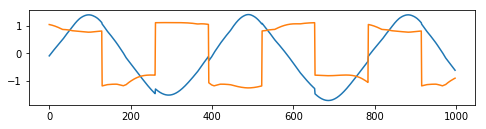

In [ ]:
shuffled_x = np.array(X)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(6001):
        current_loss, _ = sess.run([loss, train_step], feed_dict={encoding_x:shuffled_x})
        np.random.shuffle(shuffled_x)
        if i % 4 is 0: 
            current_loss, _ = sess.run([loss, train_encoder], feed_dict={encoding_x:shuffled_x, 
                                                                        learning_rate_encoder:0.004 / (1+0.001*i)})
        if i % 100 is 0: print("step: {}, loss: {}".format(i, current_loss))         
        if i % 400 is 0:
            #v = sess.run(Wx)
            plt.figure(figsize=(8, 8))
            plt.subplot(4, 1, 1)
            encoding = sess.run(dense, feed_dict={encoding_x:X})
            plt.plot(encoding)
            plt.show()